In [1]:
import numpy as np
import pickle
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

from minicons import scorer
import scipy
import tqdm.auto as tqdm

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import torch.nn.functional as F
from modular_transformers.straightening.straightening_utils import compute_model_activations, compute_model_curvature

from torch.utils.data import Dataset
from torch.utils.data import DataLoader


tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
data_path = "/om2/user/jackking/modular_transformers/scripts/attention_interpretability"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.set_grad_enabled(False)


/om2/user/jackking/anaconda/envs/modular_transformers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datasource = "ud"
sentence_length = 10
datatype = f"{datasource}/{sentence_length}_word"
model_name = "gpt2-xl"
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

curvatures = pickle.load(open(f"{data_path}/data/{datatype}/{model_name}_curvatures.pkl", "rb"))
sentences = pickle.load(open(f"{data_path}/data/{datatype}/sentences.pkl", "rb"))

In [3]:
batch_size = 64

class SentenceDataset(Dataset):
    def __init__(self, inputs, tokenizer, max_length):
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        inputs = self.inputs[idx]
        return inputs

# finding the suprisal at each token given the full previous context

def get_statistics(model, dataloader, device):
    model.eval()
    input_surprisals = []
    predicted_surprisals = []
    entropy = []

    for batch in dataloader:
        inputs = batch.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        logits = outputs.logits
        #batch_size x seq_len x vocab_size
        # log_probs = -F.log_softmax(logits, dim=-1)
        probs = F.softmax(logits, dim=-1)
        log_probs = torch.log2(probs)

        for i in range(inputs.shape[0]):
            #for each position in the sentence, find the surprisal of the token in the next position in the input sentence
            token_indices = inputs[i, 2:].cpu().numpy()
            token_log_probs = -log_probs[i, torch.arange(1, len(token_indices)+1), token_indices]
            input_surprisals.append(token_log_probs.cpu().numpy())

            #for each token in the sentence, find the surprisal of the predicted token
            predicted_indices = torch.argmax(logits[i], dim=-1).cpu().numpy()[2:] #don't need first two
            predicted_log_probs = -log_probs[i, torch.arange(2, len(predicted_indices)+2), predicted_indices]
            predicted_surprisals.append(predicted_log_probs.cpu().numpy())

            #for each token in the sentence, find the entropy of the predicted distribution
            entropy.append(-1 * torch.sum(probs[i] * log_probs[i], dim=-1).cpu().numpy()[2:])

    #num samples x seq_len
    return np.array(input_surprisals), np.array(predicted_surprisals), np.array(entropy)

In [4]:
inputs = torch.tensor(sentences)
dataset = SentenceDataset(inputs, tokenizer, sentence_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
input_surprisals, predicted_surprisals, entropy = get_statistics(model, dataloader, device)

random_input = torch.randint(0, 50256, (len(inputs), sentence_length)).to(device)
dataset = SentenceDataset(random_input, tokenizer, sentence_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
random_input_surprisals, random_predicted_surprisals, random_entropy = get_statistics(model, dataloader, device)

activations = compute_model_activations(model, random_input, device)
random_curvatures = compute_model_curvature(activations)

  0%|          | 0/5815 [00:00<?, ?it/s]/net/vast-storage/scratch/vast/evlab/jackking/modular_transformers/modular_transformers/straightening/straightening_utils.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens_tensor = torch.tensor(indexed_tokens[i]).to(device)
100%|██████████| 5815/5815 [04:40<00:00, 20.71it/s]
5815it [02:04, 46.56it/s]


In [ ]:
#try moving up curve

In [55]:
import pingouin as pg
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats
import pandas as pd

def select_tokens(curvatures, surprisals, num_ctx, i):
    all_layer_all_curve = np.array(curvatures["all_layer_curve_all"])

    if num_ctx == -1:
        layer_curves = all_layer_all_curve[:, i, 1:].flatten()
        layer_surprisals = surprisals[:, :-1].flatten()
    elif num_ctx == 0:
        layer_curves = all_layer_all_curve[:, i, :].flatten()
        layer_surprisals = surprisals[:, :].flatten()
    elif num_ctx == "mean":
        layer_curves = all_layer_all_curve[:, i, :].mean(axis=-1)
        # layer_surprisals = surprisals[:, :].mean(axis=-1)
        layer_surprisals = surprisals[:, -1]
    else:
        # layer_curves = all_layer_all_curve[:, i, :-num_ctx].flatten()
        # layer_surprisals = surprisals[:, num_ctx:].flatten()
        layer_curves = all_layer_all_curve[:, i, -num_ctx:].mean(axis=1)
        layer_surprisals = surprisals[:, -1]
    
    return layer_curves, layer_surprisals

def is_constant(arr):
    return np.all(arr == arr[0])

# Function to get residuals from regression
def get_residuals(independent_var, dependent_var):
    independent_var = sm.add_constant(independent_var)  # Adds a constant term for the regression
    model = sm.OLS(dependent_var, independent_var).fit()  # Ordinary Least Squares Regression
    residuals = model.resid
    return residuals

# correlate with curvature
def curve_surprisal_correlation(curvatures, surprisals, random_curvatures, random_surprisals, num_ctx):
    #num samples x num layers x num tokens - 2
    all_layer_all_curve = np.array(curvatures["all_layer_curve_all"])
    correlation_matrix = np.zeros((all_layer_all_curve.shape[1]))
    pvalue_matrix = np.zeros((all_layer_all_curve.shape[1]))
    for i in range(all_layer_all_curve.shape[1]):

        layer_curves, layer_surprisals = select_tokens(curvatures, surprisals, num_ctx, i)
        random_layer_curves, random_layer_surprisals = select_tokens(random_curvatures, random_surprisals, num_ctx, i)

        # layer_curves = all_layer_all_curve[:, i, :].mean(axis=-1)
        # layer_surprisals = surprisals[:, -1]

        # corr = scipy.stats.pearsonr(layer_curves, layer_surprisals)
        # correlation_matrix[i] = corr[0]
        # pvalue_matrix[i] = corr[1]

        X = layer_curves.reshape(-1, 1)
        Y = layer_surprisals.reshape(-1, 1)
        Z = random_layer_curves.reshape(-1, 1)
        W = random_layer_surprisals.reshape(-1, 1)

        X = layer_curves
        Y = layer_surprisals
        Z = random_layer_curves
        W = random_layer_surprisals

        # # Step 1: Standardize and combine variables
        # # Step 1: Standardize the data
        # scaler = StandardScaler()
        # X_scaled = scaler.fit_transform(X)
        # Y_scaled = scaler.fit_transform(Y)
        # Z_scaled = scaler.fit_transform(Z)
        # W_scaled = scaler.fit_transform(W)

        # # Step 2: Combine X, Y and Z, W into sets
        # XY = np.hstack([X_scaled, Y_scaled])  # Combine X and Y
        # ZW = np.hstack([Z_scaled, W_scaled])  # Combine Z and W
        # # print(XY.shape, ZW.shape)

        # # Step 2: Fit CCA model
        # cca = CCA(n_components=1)
        # cca.fit(ZW, XY)

        # # Step 3: Transform to canonical variables
        # ZW_c, XY_c = cca.transform(ZW, XY)

        # # Step 4: Regress the canonical variables of (X, Y) on those of (Z, W)
        # # reg = LinearRegression().fit(ZW_c, XY_c)
        # # XY_pred = reg.predict(ZW_c)
        # ZW_to_XY = np.linalg.lstsq(ZW_c, XY_c, rcond=None)[0]
        # XY_projected = ZW_c @ ZW_to_XY 

        # # reg = LinearRegression().fit(ZW, XY)
        # # XY_pred = reg.predict(ZW)

        # # Step 5: Calculate residuals (unique part of (X, Y) not explained by (Z, W))
        # # XY_residual = XY - XY_pred
        # XY_residual = XY - XY_projected

        # # Step 6: Separate residuals of X and Y
        # # print(XY_residual.shape)
        # X_residual = XY_residual[:, 0]
        # Y_residual = XY_residual[:, 1]

        # # Step 7: Analyze the residual relationship
        # corr = np.corrcoef(X_residual, Y_residual)[0, 1]

        Z_W = np.column_stack((Z, W))
        Z_W = sm.add_constant(Z_W)  # Adds intercept term

        # Fit the regression model for Y
        model_Y = sm.OLS(Y, Z_W).fit()
        epsilon_Y = model_Y.resid  # Residuals of Y

        # Step 2: Regress X on Z and W to get residuals ε_X
        # Fit the regression model for X
        model_X = sm.OLS(X, Z_W).fit()
        epsilon_X = model_X.resid  # Residuals of X

        # Step 3: Compute the correlation between ε_X and ε_Y
        corr, p_value = stats.pearsonr(epsilon_X, epsilon_Y)

        data = pd.DataFrame({
            'Y': Y,
            'X': X,
            'Z': Z,
            'W': W
        })

        # Define the ANCOVA model: Y ~ X + Z + W
        # Using the formula API for convenience
        model = sm.formula.ols('Y ~ X + Z + W', data=data).fit()
        corr = model.rsquared_adj

        correlation_matrix[i] = corr


    return correlation_matrix, pvalue_matrix


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


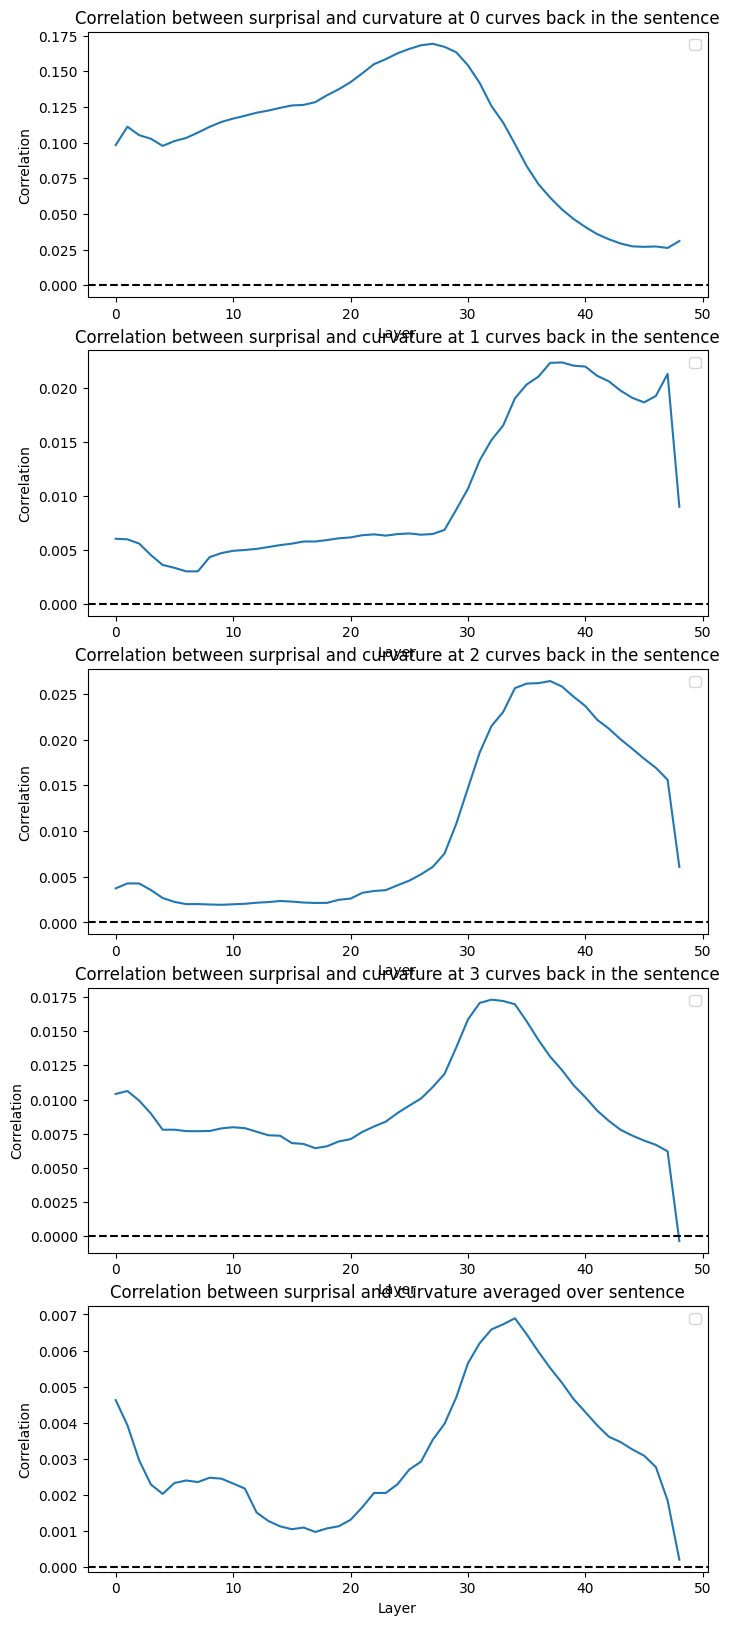

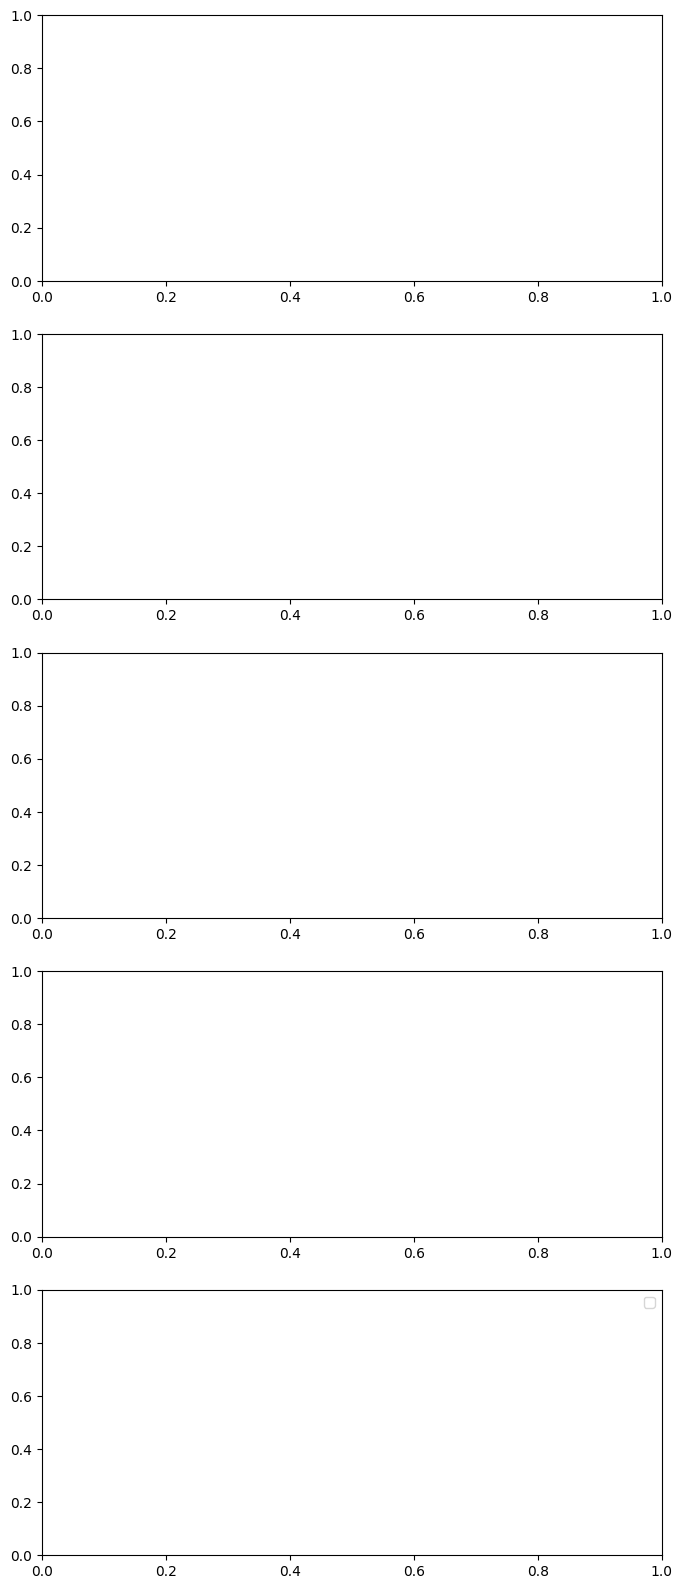

In [56]:
figure, ax = plt.subplots(5, 1, figsize=(8, 20))
figure, ax2 = plt.subplots(5, 1, figsize=(8, 20))
for i, num_ctx in enumerate([-1, 0, 1, 2, "mean"]):#, 2, 3, 4, 5, 6, 7]:
    correlation_matrix, pvalue_matrix = curve_surprisal_correlation(curvatures, predicted_surprisals, random_curvatures, random_predicted_surprisals, num_ctx)
    # ax[i].figure(figsize=(10, 5))
    ax[i].plot(correlation_matrix)
    #color = "red" if pvalue_matrix[i] < 0.05 else "black"
    cmap = {True: "red", False: "black"}
    # plt.scatter(np.arange(len(correlation_matrix)), correlation_matrix, c=[cmap[pvalue < 0.05] for pvalue in pvalue_matrix])
    # Manually create legend handles
    # red_dot = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Significant')
    # black_dot = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Not Significant')
    # # Add the legend with the custom handles
    # plt.legend(handles=[red_dot, black_dot])
    # set legend saying red is significant

    # random_correlation_matrix, pvalue_matrix = curve_surprisal_correlation(random_curvatures, random_predicted_surprisals, None, None, num_ctx)
    # ax[i].plot(random_correlation_matrix, label="Random")
    # difference = correlation_matrix - random_correlation_matrix
    # ax[i].plot(difference, label="Difference")

    ax[i].axhline(0, color="black", linestyle="--")
    ax[i].set_xlabel("Layer")
    ax[i].set_ylabel("Correlation")
    try:
        ax[i].set_title(f"Correlation between surprisal and curvature at {num_ctx + 1} curves back in the sentence")
    except:
        ax[i].set_title(f"Correlation between surprisal and curvature averaged over sentence")
    ax[i].legend()
    
plt.legend()
plt.show()

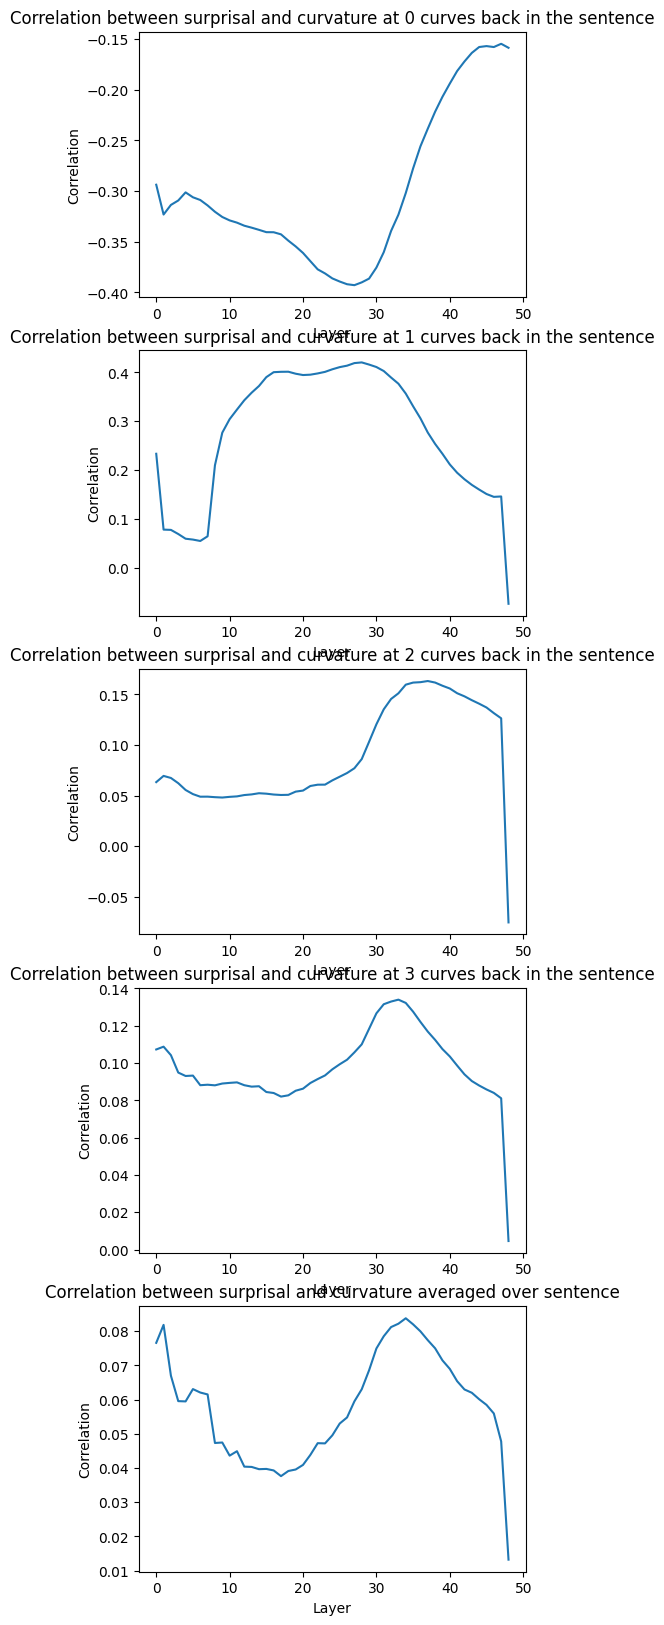

In [7]:
figure, ax = plt.subplots(5, 1, figsize=(5, 20))
for i, num_ctx in enumerate([-1, 0, 1, 2, "mean"]):#, 2, 3, 4, 5, 6, 7]:
    correlation_matrix, pvalue_matrix = curve_surprisal_correlation(curvatures, predicted_surprisals, random_curvatures, random_predicted_surprisals, num_ctx)
    # ax[i].figure(figsize=(10, 5))
    ax[i].plot(correlation_matrix)
    #color = "red" if pvalue_matrix[i] < 0.05 else "black"
    cmap = {True: "red", False: "black"}
    # plt.scatter(np.arange(len(correlation_matrix)), correlation_matrix, c=[cmap[pvalue < 0.05] for pvalue in pvalue_matrix])
    # Manually create legend handles
    # red_dot = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Significant')
    # black_dot = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Not Significant')
    # # Add the legend with the custom handles
    # plt.legend(handles=[red_dot, black_dot])
    # set legend saying red is significant

    # correlation_matrix, pvalue_matrix = curve_surprisal_correlation(random_curvatures, random_input_surprisals, None, None, num_ctx)
    # plt.plot(correlation_matrix)

    # plt.axhline(0, color="black", linestyle="--")
    ax[i].set_xlabel("Layer")
    ax[i].set_ylabel("Correlation")
    try:
        ax[i].set_title(f"Correlation between surprisal and curvature at {num_ctx + 1} curves back in the sentence")
    except:
        ax[i].set_title(f"Correlation between surprisal and curvature averaged over sentence")
plt.show()

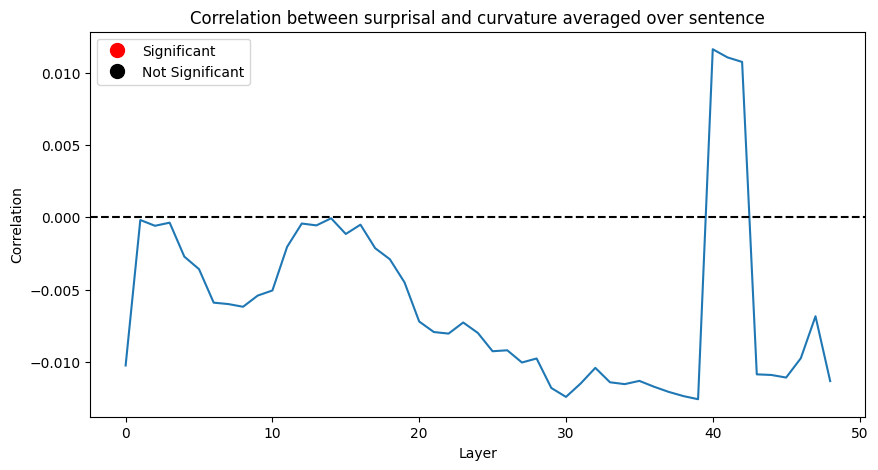

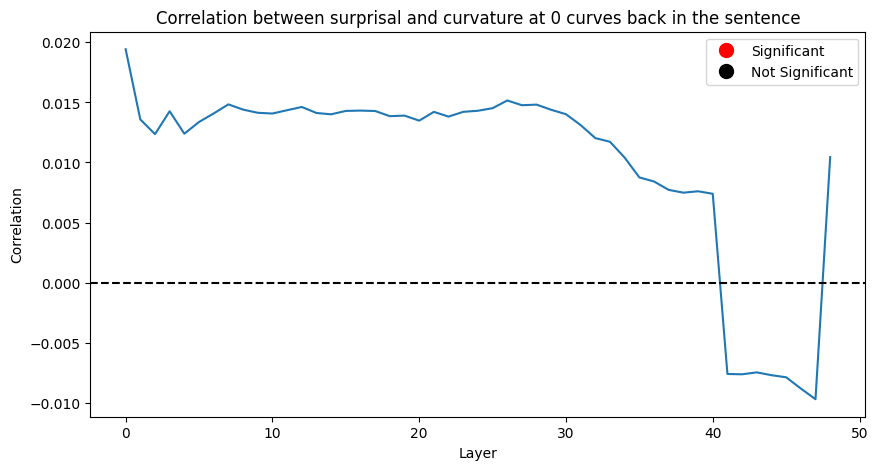

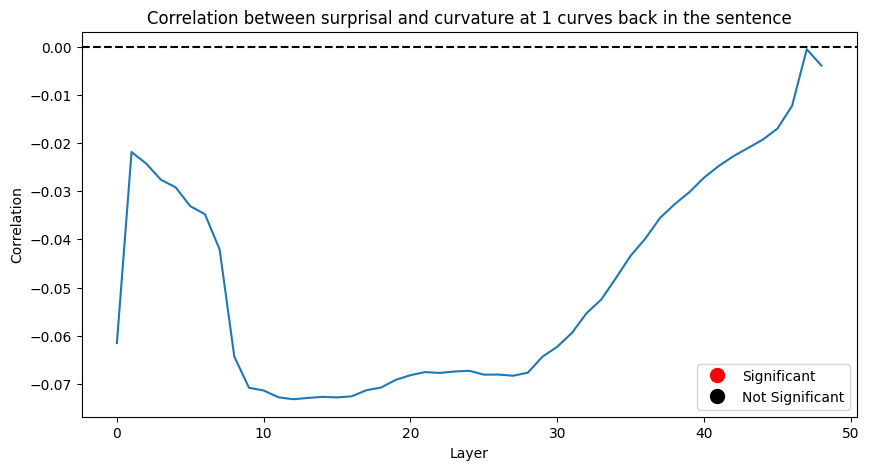

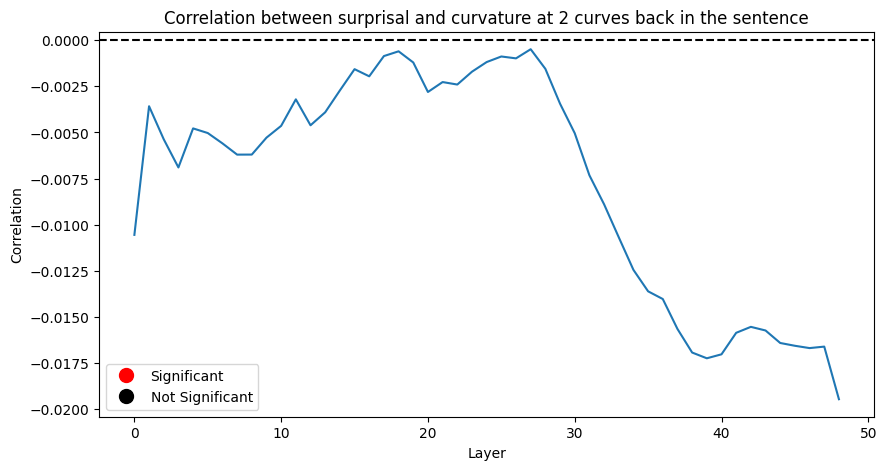

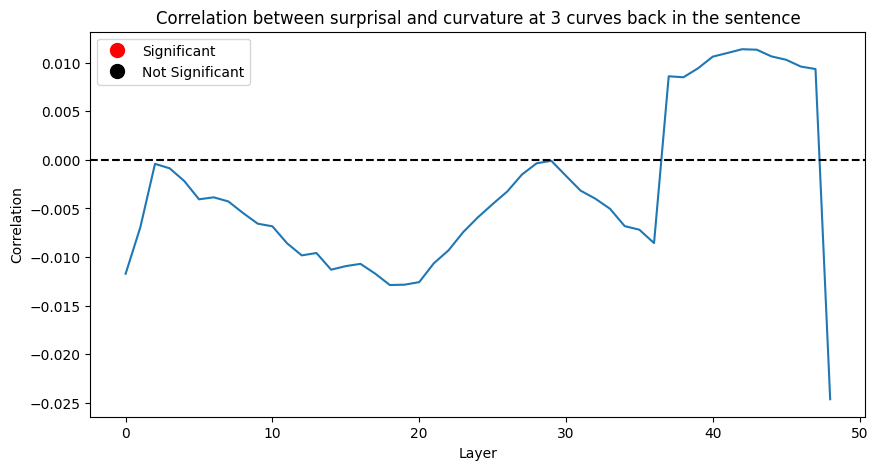

KeyboardInterrupt: 

In [32]:
for num_ctx in ["mean", -1, 0, 1]:#, 2, 3, 4, 5, 6, 7]:
    correlation_matrix, pvalue_matrix = curve_surprisal_correlation(curvatures, input_surprisals, random_curvatures, random_input_surprisals, num_ctx)
    plt.figure(figsize=(10, 5))
    plt.plot(correlation_matrix)
    #color = "red" if pvalue_matrix[i] < 0.05 else "black"
    cmap = {True: "red", False: "black"}
    # plt.scatter(np.arange(len(correlation_matrix)), correlation_matrix, c=[cmap[pvalue < 0.05] for pvalue in pvalue_matrix])
    # Manually create legend handles
    red_dot = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Significant')
    black_dot = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Not Significant')
    # Add the legend with the custom handles
    plt.legend(handles=[red_dot, black_dot])
    # set legend saying red is significant

    # correlation_matrix, pvalue_matrix = curve_surprisal_correlation(curvatures, random_input_surprisals, num_ctx)
    # plt.plot(correlation_matrix)

    plt.axhline(0, color="black", linestyle="--")
    plt.xlabel("Layer")
    plt.ylabel("Correlation")
    try:
        plt.title(f"Correlation between surprisal and curvature at {num_ctx + 1} curves back in the sentence")
    except:
        plt.title(f"Correlation between surprisal and curvature averaged over sentence")
    plt.show()

0


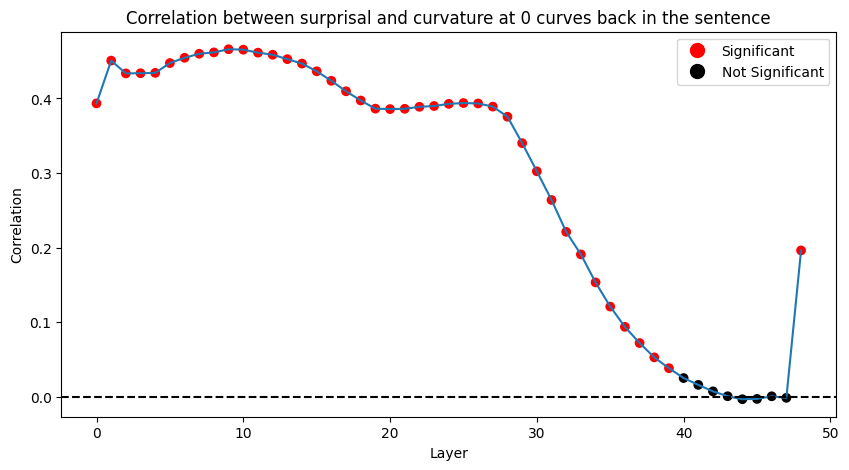

1


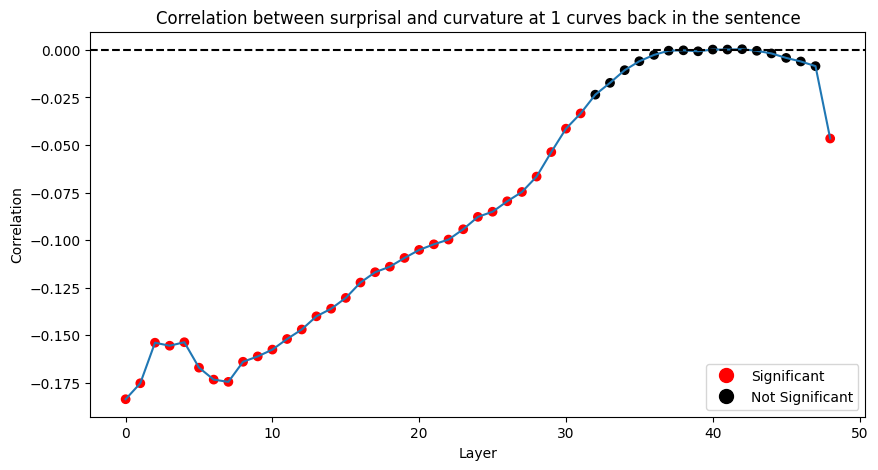

2


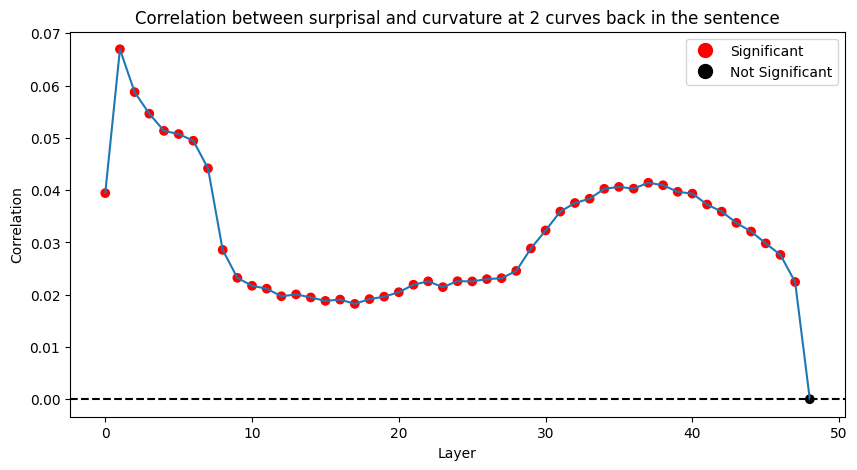

3


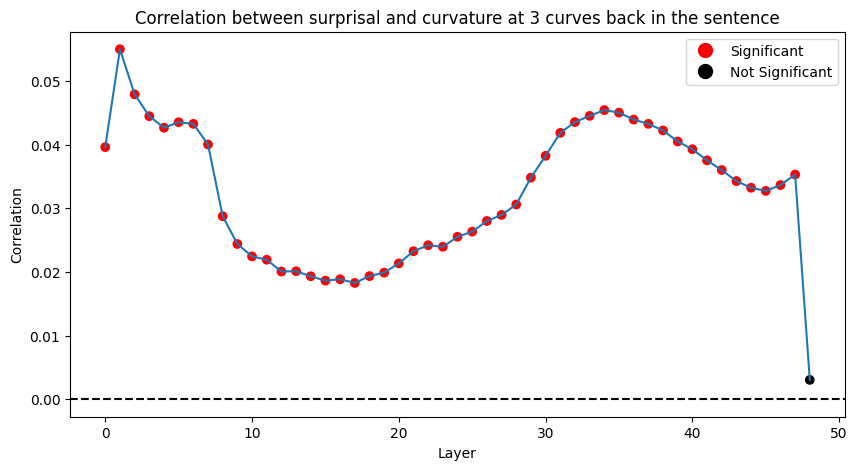

4


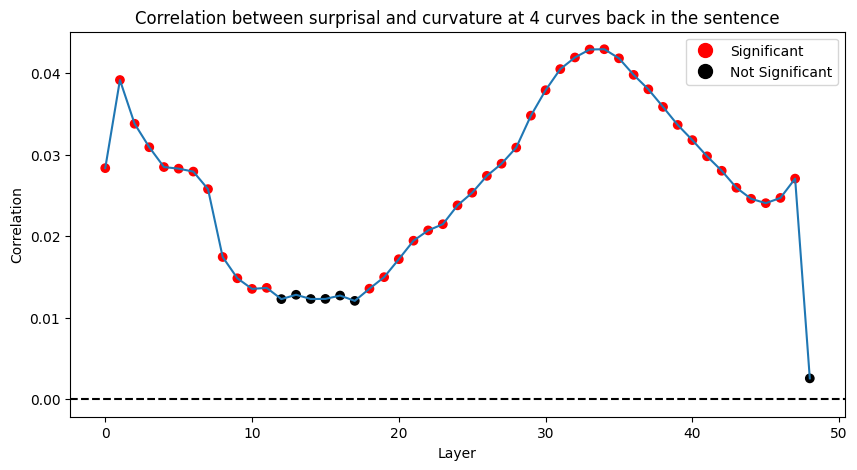

5


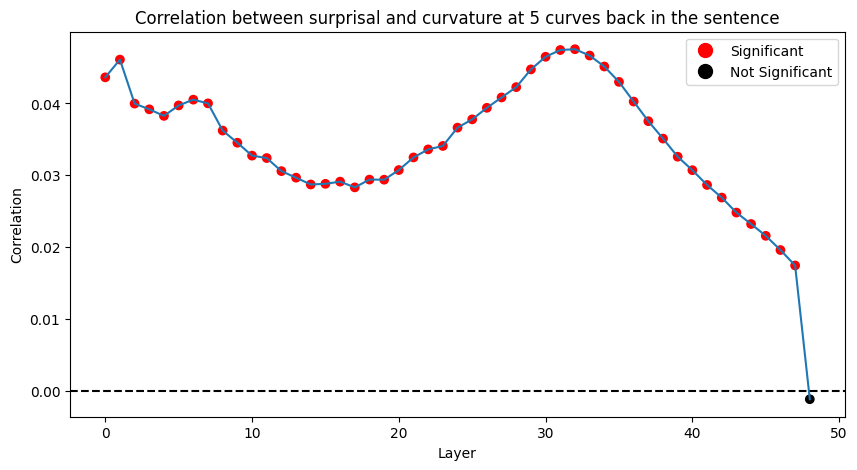

6


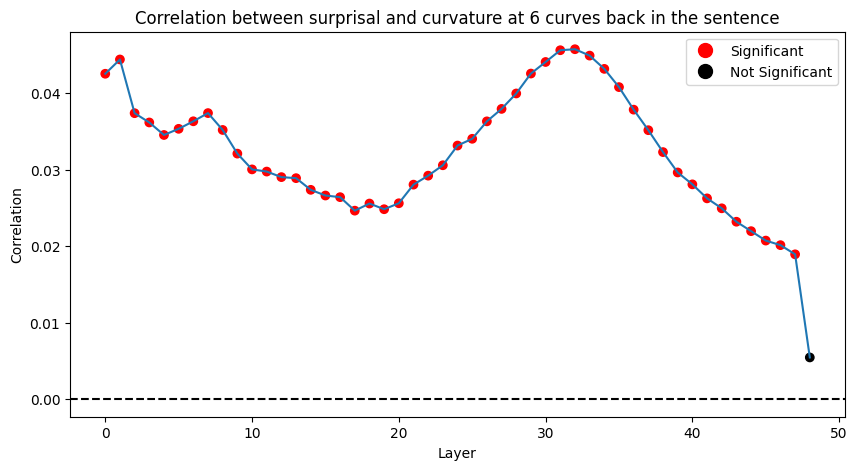

7


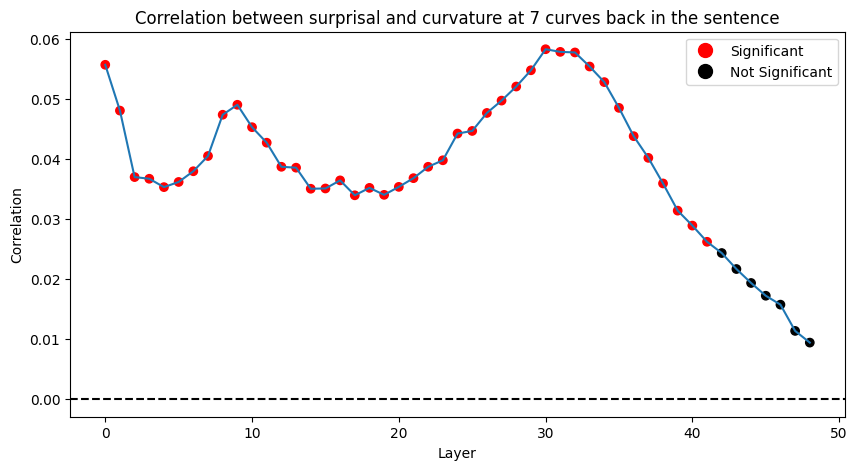

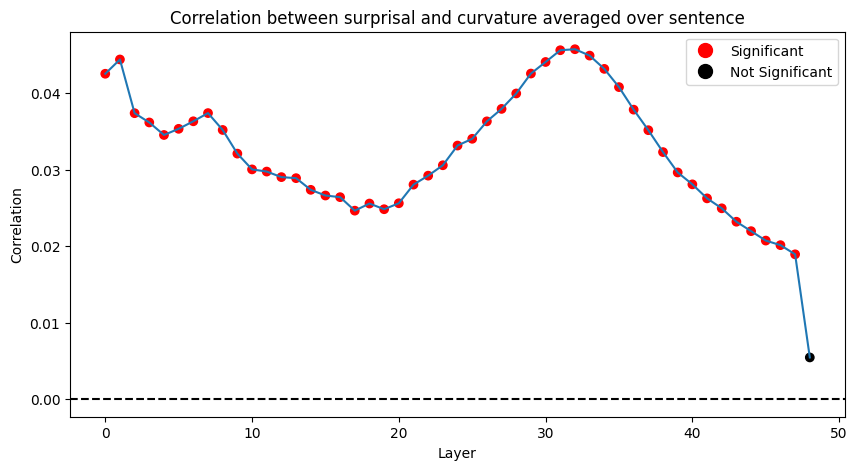

In [29]:
#correlate with curvature
def curve_surprisal_correlation(curvatures, surprisals, num_ctx, aggregated=False, bump=0):
    #num samples x num layers x num tokens - 2
    all_layer_all_curve = np.array(curvatures["all_layer_curve_all"])
    correlation_matrix = np.zeros((all_layer_all_curve.shape[1]))
    pvalue_matrix = np.zeros((all_layer_all_curve.shape[1]))
    for i in range(all_layer_all_curve.shape[1]):
        if num_ctx == 1:
            layer_curves = all_layer_all_curve[:, i, :].flatten()
            layer_surprisals = surprisals[:, -1].flatten()
            layer_curves = all_layer_all_curve[:, i, :].mean(axis=-1)
            # layer_surprisals = surprisals[:, :].mean(axis=-1)
        elif num_ctx == 0:
            # layer_curves = all_layer_all_curve[:, i, 1:].flatten()
            # layer_surprisals = surprisals[:, :-1].flatten()
            layer_curves = all_layer_all_curve[:, i, -1].flatten()
            layer_surprisals = surprisals[:, -2].flatten()
        elif aggregated:
            layer_curves = np.zeros((all_layer_all_curve.shape[0], all_layer_all_curve.shape[2] - num_ctx - bump))
            for j in range(all_layer_all_curve.shape[2] - num_ctx - bump):
                layer_curves[:, j] = all_layer_all_curve[:, i, j+bump:j+num_ctx+bump].mean(axis=-1)
            # print(layer_curves.shape)
            layer_curves = layer_curves.flatten()
            if bump == 0:
                layer_surprisals = surprisals[:, num_ctx:].flatten()
            else:
                layer_surprisals = surprisals[:, num_ctx:-bump].flatten()
        else:
            layer_curves = all_layer_all_curve[:, i, :-num_ctx].flatten()
            layer_surprisals = surprisals[:, num_ctx:].flatten()

        # corr = np.corrcoef(layer_curves, layer_surprisals)
        # correlation_matrix[i] = corr[0, 1]
        corr = scipy.stats.pearsonr(layer_curves, layer_surprisals)
        correlation_matrix[i] = corr[0]
        pvalue_matrix[i] = corr[1]
        # print(f"Layer {i} correlation: {corr[0]}")
        # print(f"Layer {i} p-value: {corr[1]}")
        # plt.scatter(layer_curves, layer_surprisals)
        # plt.show()

    return correlation_matrix, pvalue_matrix

num_ctx = 1

for num_ctx in [0, 1, 2, 3, 4, 5, 6, 7]:
    print(num_ctx)
    correlation_matrix, pvalue_matrix = curve_surprisal_correlation(curvatures, input_surprisals, num_ctx, aggregated=True, bump=0)
    plt.figure(figsize=(10, 5))
    plt.plot(correlation_matrix)
    #color = "red" if pvalue_matrix[i] < 0.05 else "black"
    cmap = {True: "red", False: "black"}
    plt.scatter(np.arange(len(correlation_matrix)), correlation_matrix, c=[cmap[pvalue < 0.05] for pvalue in pvalue_matrix])
    # Manually create legend handles
    red_dot = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Significant')
    black_dot = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Not Significant')

    # Add the legend with the custom handles
    plt.legend(handles=[red_dot, black_dot])
    # set legend saying red is significant

    plt.axhline(0, color="black", linestyle="--")
    plt.xlabel("Layer")
    plt.ylabel("Correlation")
    plt.title(f"Correlation between surprisal and curvature at {num_ctx} curves back in the sentence")
    plt.show()

correlation_matrix, pvalue_matrix = curve_surprisal_correlation(curvatures, input_surprisals, 6, aggregated=True, bump=0)
plt.figure(figsize=(10, 5))
plt.plot(correlation_matrix)
#color = "red" if pvalue_matrix[i] < 0.05 else "black"
cmap = {True: "red", False: "black"}
plt.scatter(np.arange(len(correlation_matrix)), correlation_matrix, c=[cmap[pvalue < 0.05] for pvalue in pvalue_matrix])
# Manually create legend handles
red_dot = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Significant')
black_dot = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Not Significant')

# Add the legend with the custom handles
plt.legend(handles=[red_dot, black_dot])
# set legend saying red is significant

plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Layer")
plt.ylabel("Correlation")
plt.title(f"Correlation between surprisal and curvature averaged over sentence")
plt.show()

